In [1]:
%matplotlib inline

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow.keras as keras
from tensorflow.keras import layers
# from tensorflow.keras import ops
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import string
import random
import tensorflow as tf
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph, IndexedArray
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph import datasets, utils
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import ComplEx

from IPython.display import HTML

from graph_visualization import GraphVisualization

print("Tensorflow verions:", tf.__version__)
print('Available GPUs:', tf.config.experimental.list_physical_devices('GPU'))

Tensorflow verions: 2.4.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.convert_to_tensor([1, 1])], 0
    )
    return tf.tile(mask, mult)

def causal_attention_mask_(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.convert_to_tensor([1, 1])], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, "bool")
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

    def get_weights(self):
        return [self.att.get_weights(), self.ffn.layers[0].get_weights(), self.ffn.layers[1].get_weights()]

    def set_weights(self, weights):
        self.att.set_weights(weights[0])
        self.ffn.layers[0].set_weights(weights[1])
        self.ffn.layers[1].set_weights(weights[2])

In [3]:
vocab_size = 30  # Only consider the top 20k words
maxlen = 10  # Max sequence size
batch_size = 128

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "gpt-dataset/custom-2.6"
]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))

# filenames = filenames[:10000]

print(f"{len(filenames)} files")

# Create a dataset from text files
random.shuffle(filenames)
text_ds = tf_data.TextLineDataset(filenames)

def custom_standardization(input_string):
    """Remove html line-break tags and handle punctuation"""
    lowercased = tf_strings.lower(input_string)
    stripped_html = tf_strings.regex_replace(lowercased, "<br />", " ")
    return tf_strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

from sklearn.feature_extraction.text import CountVectorizer
def count_occurences(text_ds):

    def preprocess_text(text):
        # Custom text preprocessing
        # For example, you can perform lowercasing, punctuation removal, etc.
        return text.lower()
    
    # Preprocess the text data and convert it to a list
    preprocessed_texts = [preprocess_text(str(text.numpy())) for text in text_ds]
    # Initialize CountVectorizer
    vectorizer = CountVectorizer()
    # Fit CountVectorizer on preprocessed text data and transform it into token counts
    token_counts = vectorizer.fit_transform(preprocessed_texts)
    # Get the vocabulary and token counts
    vocab = vectorizer.get_feature_names_out()
    counts = token_counts.toarray().sum(axis=0)
    # Create a dictionary to store token counts
    token_counts_dict = dict(zip(vocab, counts))

    token_counts_dict = sorted(token_counts_dict.items(), key=lambda item: item[1], reverse=True)
    
    print(token_counts_dict)

# count_occurences(text_ds)

def filter_dataset(line):
    return not tf.strings.regex_full_match(line, ".*\\bpiano\\b.*")

text_ds = text_ds.filter(lambda line: filter_dataset(line))

text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)

# for text in text_ds:
#     print(str(text.numpy()))

3 files


In [4]:
def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]

    # zeros_column = tf.zeros_like(y[:, :1])  # Create a column of zeros with the same shape as the first column of y
    # y = tf.concat([zeros_column, y], axis=1)  # Concatenate the zeros column with y along the column axis

    return x, y

text_ds = text_ds.map(prepare_lm_inputs_labels, num_parallel_calls=tf_data.AUTOTUNE)
text_ds = text_ds.prefetch(tf_data.AUTOTUNE)

def prepare_node_vector_outputs(text_ds, node_embeddings):
    def process(x,y):
        return x, tf.gather(node_embeddings, y)
        
    return text_ds.map(process, num_parallel_calls=tf_data.AUTOTUNE)

In [5]:
sources = ['guitar', 'guitar', 'guitar', 'violin', 'violin', 'violin', 'piano', 'piano', 'piano', 
           'car', 'car', 'car', 'truck', 'truck', 'truck', 'neck', 'strings', 'keys', 'pedals', 
           'wheels', 'baggage', 'trunk', 'instrument', 'vehicle', 'trombone', 'trombone', 'trombone', 'bell', 'slide']
labels = ['is', 'has', 'has', 'is', 'has', 'has', 'is', 'has', 'has', 'is', 'has', 'has', 'is',
          'has', 'has', 'is', 'is', 'is', 'is', 'is', 'is', 'is', 'has', 'has', 'is', 'has', 'has', 'is', 'is']
targets = ['instrument', 'neck', 'strings', 'instrument', 'neck', 'strings', 'instrument', 'keys', 
           'pedals', 'vehicle', 'wheels', 'baggage', 'vehicle', 'wheels', 'trunk', 'part', 'part', 
           'part', 'part', 'part', 'part', 'part', 'part', 'part', 'instrument', 'bell', 'slide', 'part', 'part']

sources.extend(['organ', 'organ', 'organ'])
labels.extend(['is', 'has', 'has'])
targets.extend(['instrument', 'keys', 'pedals'])

graph_data = pd.DataFrame({'source': sources, 'label': labels, 'target': targets})

rel_graphs = {}
for index, row in graph_data.iterrows():
    df = rel_graphs.get(row['label'], pd.DataFrame({'source': [], 'label': [], 'target': []}))
    df = df.append({'source': row['source'], 'label': row['label'], 'target': row['target']}, ignore_index=True)
    rel_graphs[row['label']] = df
    
# graph_data

In [6]:
graph_embedding_size = 10

def node2vec(G):
        walk_length = 100
        rw = BiasedRandomWalk(G)
        walks = rw.run(
            nodes=G.nodes(),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=10,  # number of random walks per root node
            p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
            q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
            weighted=False,  # for weighted random walks
            seed=42,  # random seed fixed for reproducibility
        )

        model = Word2Vec(
            walks,  vector_size=graph_embedding_size, window=5, min_count=0, sg=1, workers=1
        )

        return pd.DataFrame([(key, vector) for key,vector in zip(model.wv.index_to_key, model.wv.vectors)], columns=['node', 'embedding'])

def fill_graph(graph, vocab):
    for word in vocab:
        graph['nodes'].append(word) if word not in graph['nodes'] else None

    return graph
    
def get_graph(graph_data):
    nodes, edges, edge_types = [], [], []

    for word in graph_data['source'].unique():
        nodes.append(word)

    for word in graph_data['target'].unique():
        nodes.append(word) if word not in nodes else None

    for index, row in graph_data.iterrows():
        edges.append({'source': row['source'], 'target': row['target']})
        edge_types.append(row['label'])

    graph = {'nodes':nodes, 'edges': edges, 'edge_types': edge_types}

    graph = fill_graph(graph, vocab)
    
    edges_ = pd.DataFrame({
            'source': [e['source'] for e in graph['edges']],
            'target': [e['target'] for e in graph['edges']],
            'type': graph['edge_types']
        })

    G = StellarGraph(IndexedArray(index=graph['nodes']), edges_, edge_type_column="type")
    
    return graph, G

def get_embeddings(G):
    node_embeddings = complex_embeddings(G, conceptnet_data[['source','label','target']])
        
    return node_embeddings
    
graph, G = get_graph(graph_data)
full_embeddings = node2vec(G)

tmp = []
for i,word in enumerate(vocab):
    lower_nodes = list(map(lambda k: k.lower(), full_embeddings['node']))
    index = lower_nodes.index(word.lower()) if word.lower() in lower_nodes else -1
    if index != -1:
        tmp.append(full_embeddings.iloc[index][1])
    else:
        tmp.append(np.ones(graph_embedding_size) * -10)

full_embeddings = np.array(tmp)

graphs, node_embeddings = [], []
for key, _graph_data in rel_graphs.items():
    _graph, G = get_graph(_graph_data)
    graphs.append(_graph)
    node_embeddings.append(node2vec(G))

for j, emb in enumerate(node_embeddings):
    tmp = []
    lower_nodes = list(map(lambda k: k.lower(), emb['node']))
    for i,word in enumerate(vocab):
        index = lower_nodes.index(word.lower()) if word.lower() in lower_nodes else -1
        if index != -1:
            tmp.append(emb.iloc[index][1])
        else:
            tmp.append(np.ones(graph_embedding_size) * -10)
    
    node_embeddings[j] = np.array(tmp).tolist()

node_embeddings = np.array(node_embeddings)

In [7]:
final_embeddings = None
for i in range(0, node_embeddings.shape[0] - 1):
    embeddings =  np.concatenate((node_embeddings[i], node_embeddings[i + 1]), axis=1)
    final_embeddings = embeddings if not final_embeddings else np.concatenate((final_embeddings, embeddings), axis = 1) 

# final_embeddings = node_embeddings[0]
# final_embeddings = node_embeddings[0]
# final_embeddings = np.concatenate((final_embeddings, full_embeddings), axis=1)
final_embeddings.shape

(27, 20)

In [8]:
_graph = graph
# _graph = graphs[0]
index = 0
vis = GraphVisualization()
for edge in _graph['edges'][index:]:
    vis.addEdge(edge['source'], edge['target'])
# vis.visualize()

In [9]:
from numpy.linalg import norm

def cosine_sim(A,B):
    return np.dot(A,B)/(norm(A)*norm(B))

def euclidean_distance(vector1, vector2):
    """Calculate the Euclidean distance between two vectors."""
    # Ensure both vectors are NumPy arrays
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    
    # Calculate the squared differences between corresponding elements
    squared_diff = np.square(vector1 - vector2)
    
    # Sum the squared differences and take the square root
    distance = np.sqrt(np.sum(squared_diff))
    
    return distance

In [10]:
# index_A = vocab.index('guitar')
# index_B = vocab.index('neck')
# index_C = vocab.index('piano')
# index_D = vocab.index('keys')
# index_E = vocab.index('trombone')
# index_F = vocab.index('bell')
# index_G = vocab.index('instrument')

# embeddings = node_embeddings[0]
# # embeddings = final_embeddings
# A,B,C,D,E,F,G = embeddings[index_A], embeddings[index_B], embeddings[index_C], embeddings[index_D], embeddings[index_E], embeddings[index_F], embeddings[index_G]
# print('Cosine Similarities: ')
# print('A, B: ', cosine_sim(A,B), '\nA, C: ', cosine_sim(A,C), '\nA, D: ', cosine_sim(A,D), 
#       '\nB, C: ',cosine_sim(B,C), '\nB, D: ', cosine_sim(B,D), '\nC, D: ', cosine_sim(C,D),
#       '\nA, E: ',cosine_sim(A,E), '\nB, E: ', cosine_sim(B,E), '\nE, F: ', cosine_sim(E,F),
#       '\nC, F: ',cosine_sim(C,F), '\nD, F: ', cosine_sim(D,F), '\nA, G: ', cosine_sim(A,G),
#       '\nB, G: ', cosine_sim(B,G), '\nE, G: ', cosine_sim(E,G))
# print('Euclidean Distances: ')
# print('A, B: ', euclidean_distance(A,B), '\nA, C: ', euclidean_distance(A,C), '\nA, D: ', euclidean_distance(A,D), 
#       '\nB, C: ',euclidean_distance(B,C), '\nB, D: ', euclidean_distance(B,D), '\nC, D: ', euclidean_distance(C,D),
#       '\nA, E: ',euclidean_distance(A,E), '\nB, E: ', euclidean_distance(B,E), '\nE, F: ', euclidean_distance(E,F),
#       '\nC, F: ',euclidean_distance(C,F), '\nD, F: ', euclidean_distance(D,F), '\nA, G: ', euclidean_distance(A,G),
#       '\nB, G: ', euclidean_distance(B,G), '\nC, G: ', euclidean_distance(C,G), '\nD, G: ', euclidean_distance(D,G),
#       '\nE, G: ', euclidean_distance(E,G), '\nF, G: ', euclidean_distance(F,G))

In [11]:
graph_ds = prepare_node_vector_outputs(text_ds, final_embeddings)
graph_ds = graph_ds.prefetch(tf_data.AUTOTUNE)

In [12]:
graph_ds, text_ds

(<PrefetchDataset shapes: ((None, 10), (None, 10, 20)), types: (tf.int64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 10), (None, 10)), types: (tf.int64, tf.int64)>)

In [13]:
# [(word, emb) for word, emb in zip(vocab, final_embeddings)]

In [14]:
class TextGenerator(tf.keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, node_embeddings, model = None, top_k=10, print_every=1, method='euclidean'
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k
        if model: self.model = model
        self.yes_count = 0
        self.no_count = 0
        self.activation_outputs = []
        self.gradients = []
        self.node_embeddings = node_embeddings
        self.normalized_node_embeddings = tf.nn.l2_normalize(tf.constant(node_embeddings, dtype=tf.float32), axis=1)
        self.method = method

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = tf.convert_to_tensor(indices, dtype=tf.int32)
        preds = tf.keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = tf.convert_to_tensor(preds, dtype=tf.float32)
  
        # Reshape logits to a matrix
        logits_matrix = tf.reshape(logits, (1, -1))
   
        # Sample from the softmax probabilities
        sampled_index = tf.random.categorical(tf.math.log(preds)[tf.newaxis, :], num_samples=1)

        # Return the sampled index
        return indices[sampled_index[0, 0]]

    def detokenize(self, number):
        return self.index_to_word[number] if number < len(self.index_to_word) else '---'

    def euclidean_distance(self, y):
        t_1 = tf.cast(self.node_embeddings, dtype=tf.float32)
        t_2 = tf.cast(tf.tile(tf.expand_dims(y,0), [self.node_embeddings.shape[0], 1]), dtype=tf.float32)
        squared_diff = tf.square(t_1 - t_2)
        
        # Sum the squared differences along the appropriate axis
        distances = tf.sqrt(tf.reduce_sum(squared_diff, axis=-1))
        distances =  tf.transpose(distances) 

        # distances, indices = tf.math.top_k(tf.negative(distances), k=self.k, sorted=True)
        # preds = tf.keras.activations.softmax(tf.expand_dims(distances,0))[0]
        # preds = tf.convert_to_tensor(preds, dtype=tf.float32)

        # sampled_index = tf.random.categorical(tf.negative(tf.math.log(preds))[tf.newaxis, :], num_samples=1)
    
        return distances, tf.argmin(distances)
    
    def cosine_similarity(self, y):
  
        # Calculate the dot product of the matrix and the vector
        dot_product = tf.reduce_sum(self.node_embeddings * y, axis=-1)
        
        # Calculate the magnitudes of the matrix and the vector
        matrix_magnitude = tf.norm(self.node_embeddings, axis=-1)
        vector_magnitude = tf.norm(y)
        
        # Calculate the cosine similarity
        cosine_similarity = dot_product / (matrix_magnitude * vector_magnitude)
                
        # similarities, indices = tf.math.top_k(similarities, k=self.k, sorted=True)
        # preds = tf.keras.activations.softmax(similarities)[0]
        # preds = tf.convert_to_tensor(preds, dtype=tf.float32)

        # indices = indices[0]

        # sampled_index = tf.random.categorical(tf.math.log(preds), num_samples=1)
        
        # Return the sampled index
        return cosine_similarity, tf.argmax(cosine_similarity)
        
    def generate_token(self, start_tokens, tokens_generated):
        pad_len = maxlen - len(start_tokens)
        sample_index = len(start_tokens) - 1
        if pad_len < 0:
            x = start_tokens[:maxlen]
            sample_index = maxlen - 1
        elif pad_len > 0:
            x = start_tokens + [0] * pad_len
        else:
            x = start_tokens
        x = np.array([x])
        y = self.model.predict(x, verbose=0)
        measurements, sample_token = self.euclidean_distance(y[0][sample_index]) if self.method == 'euclidean' else self.cosine_similarity(y[0][sample_index])
        tokens_generated.append(sample_token)
        start_tokens.append(sample_token)
        num_tokens_generated = len(tokens_generated)

        return start_tokens, tokens_generated, num_tokens_generated, y, measurements

    def get_generated_text(self, tokens_generated):
        return " ".join(
            [self.detokenize(_) for _ in tokens_generated])
        
    def get_text(self, tokens_generated):
        return " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated])
        
    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        raw_outputs = []
        while num_tokens_generated <= self.max_tokens:
            start_tokens, tokens_generated, num_tokens_generated, raw_output, measurements = self.generate_token(start_tokens, tokens_generated)
            raw_outputs.append(raw_output)
            
        txt = self.get_text(tokens_generated)
        print(f"generated text:\n{txt}\n")

        self.yes_count += 1 if 'yes' in txt else 0
        self.no_count += 1 if 'no' in txt else 0

        return txt, raw_outputs
    
    def generate(self):
        return self.on_epoc_end(1)

# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

def callback(start_prompt, model=None, top_k=10, method='euclidean'):
    start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
    num_tokens_generated = 10
    return TextGenerator(num_tokens_generated, start_tokens, vocab, final_embeddings, top_k=top_k, method=method) if not model else TextGenerator(num_tokens_generated, start_tokens, vocab, final_embeddings, model, top_k, method=method)

In [15]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]  # Modified line
        positions = tf.range(0, maxlen, 1)  # Modified line
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [36]:
class NodeEmbedding(layers.Layer):
    def __init__(self, node_embed_dim, node_embeddings, **kwargs):
        super().__init__(**kwargs)
        self.node_embeddings = tf.constant(node_embeddings, dtype=tf.float32)
        self.dense = layers.Dense(node_embed_dim)

    def call(self, x):
         # Reshape x to add a new dimension for embedding
        node_indices = tf.cast(tf.math.round(x), tf.int32)
        node_emb = tf.gather(self.node_embeddings, node_indices)
        node_emb = self.dense(node_emb)  # Apply dense layer to each token embedding
        return node_emb

In [17]:
print_output = False

In [53]:
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer
node_embedding_dim = graph_embedding_size * 2

def get_node_embedding_weights(model):
    return model.get_layer('node_embedding_layer').get_weights()

def set_node_embedding_weights(model, weights):
    return model.get_layer('node_embedding_layer').set_weights(weights)

def get_transformer_weights(model, transformer_name, output_name):
    weights = []
    weights.append(model.get_layer(transformer_name).get_weights())
    weights.append(model.get_layer(output_name).get_weights())
    return weights
    
def set_transformer_weights(model, transformer_name, output_name, weights):
    model.get_layer(transformer_name).set_weights(weights[0])
    model.get_layer(output_name).set_weights(weights[1])

def cosine_similarity_loss(y_true, y_pred):
    if print_output:
        for y_p, y_t in zip(y_pred, y_true):
            similarities_p_list, tokens_p_list, similarities_t_list, tokens_t_list = [], [], [], []
            for i in range(maxlen):
                similarities_p, tokens_p = generator.cosine_similarity(y_p[i])
                similarities_t, tokens_t = generator.cosine_similarity(y_t[i])
                similarities_p_list.append(similarities_p)
                tokens_p_list.append(tokens_p)
                similarities_t_list.append(similarities_t)
                tokens_t_list.append(tokens_t)
    
            print('real: ', ' '.join([vocab[token] for token in tokens_t_list]))
            print('prediction: ', ' '.join([vocab[token] for token in tokens_p_list]))
            print('---------')
            
    # Normalize the vectors
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    
    # Calculate cosine similarity
    cosine_similarities = tf.reduce_sum(tf.multiply(y_true_normalized, y_pred_normalized), axis=-1)

    # if print_output:
    # tf.print(1 - cosine_similarities, summarize=-1)
    
    # Return 1 - cosine similarity as the loss
    return 1 - cosine_similarities
    
def euclidean_distance_loss(y_true, y_pred):
    if print_output:
        for y_p, y_t in zip(y_pred, y_true):
            distances_p_list, tokens_p_list, distances_t_list, tokens_t_list = [], [], [], []
            for i in range(maxlen):
                distances_p, tokens_p = generator.euclidean_distance(y_p[i])
                distances_t, tokens_t = generator.euclidean_distance(y_t[i])
                distances_p_list.append(distances_p)
                tokens_p_list.append(tokens_p)
                distances_t_list.append(distances_t)
                tokens_t_list.append(tokens_t)
    
            print('real: ', ' '.join([vocab[token] for token in tokens_t_list]))
            print('prediction: ', ' '.join([vocab[token] for token in tokens_p_list]))
            print('---------')

    # Calculate the squared differences between corresponding elements
    squared_diff = tf.square(y_true - y_pred)
    
    # Sum the squared differences along the appropriate axis
    loss = tf.reduce_sum(squared_diff, axis=-1)

    return loss

tf.config.run_functions_eagerly(True)

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype="float32")
    
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim, name='embedding_layer')
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim, name='transformer_layer')
    x = transformer_block(x)

    outputs_1 = layers.Dense(vocab_size, name='text_output')(x)

    node_embedding_layer = NodeEmbedding(embed_dim, final_embeddings, name='node_embedding_layer')
    x2 = node_embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim, name='node_transformer_layer')
    x2 = transformer_block(x2)

    # Calculate final output node embeddings
    outputs_2 = layers.Dense(node_embedding_dim, name='graph_embedding_output')(x2)
    
    # Concatenate outputs of both branches
    # outputs = layers.Average()([outputs_1, outputs_2])

    outputs = outputs_2

    # Softmax layer
    # softmax_output = layers.Softmax()(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=[outputs])
    # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss=[euclidean_distance_loss],
        metrics=['mse']
    )  # No loss and optimization based on word embeddings from transformer block
    return model

model = create_model()
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
node_embedding_layer (NodeEm (None, 10, 256)           5376      
_________________________________________________________________
node_transformer_layer (Tran (None, 10, 256)           658688    
_________________________________________________________________
graph_embedding_output (Dens (None, 10, 20)            5140      
Total params: 669,204
Trainable params: 669,204
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(graph_ds, verbose=0, epochs=1, callbacks=[])

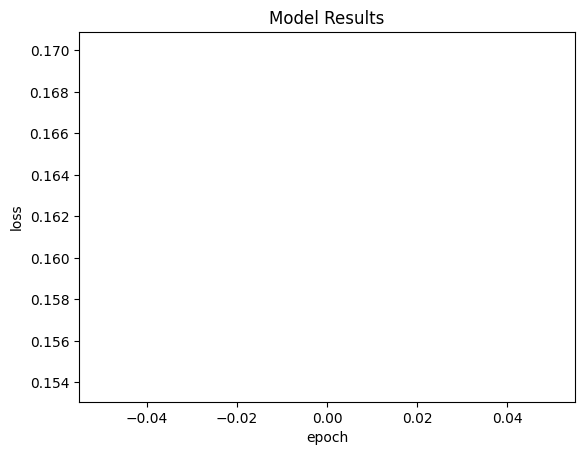

In [56]:
# plt.plot(history.history['mse'])
plt.plot(history.history['loss'])
plt.title('Model Results')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['mse', 'loss'], loc='upper right')
plt.show()

In [31]:
emb =  final_embeddings[vocab.index('organ')]
yy = final_embeddings[vocab.index('piano')]
emb, yy, euclidean_distance(emb,yy)

(array([ 0.05827279,  0.21146941, -0.85853446, -0.43476775,  0.40713334,
        -0.25533229, -1.6402235 , -1.53358591, -1.00686014, -0.21894898,
        -0.7027967 ,  0.25331518,  0.79552972, -0.1075513 ,  2.13654089,
         0.67802596,  0.36790338,  0.60496593, -1.54008281,  0.52877772]),
 array([ 0.08457045,  0.07382888, -0.76764679, -0.2136212 ,  0.42639551,
        -0.38833165, -1.69149566, -1.58441067, -0.98150045, -0.37401339,
        -0.58786553,  0.30561456,  0.78456491, -0.25285125,  2.040241  ,
         0.73948634,  0.36479887,  0.50576001, -1.55167174,  0.54063368]),
 0.43025208086981603)

In [324]:
emb =  [-0.21549219,  0.09164345,  0.1297471,   0.14354843]
yy = [-0.5062725,   0.06012138,  1.0717416,   1.781855]
emb, yy, euclidean_distance(emb,yy)

([-0.21549219, 0.09164345, 0.1297471, 0.14354843],
 [-0.5062725, 0.06012138, 1.0717416, 1.781855],
 0.7833428784823357,
 1.9123150590099414,
 array([8.45531887e-02, 9.93640897e-04, 8.87353638e-01, 2.68404842e+00]),
 1.9123150590099414)

In [63]:
result = generator.model.predict([[2, 4, 5, 12, 3, 6, 23, 0, 0, 0]])
_, token = generator.euclidean_distance(result[0][5])
vocab[token]

'instrument'

In [58]:
generator = callback('what does a piano have ?', model, 1)
output = generator.on_epoch_end(0)

generated text:
what does a piano have ? pedals .         



In [60]:
graph_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('graph_embedding_output').output)
text = 'what does a piano have ?'
generator = callback(text, graph_model, 1)
start_tokens, tokens_generated, num_tokens_generated, raw_output, distances = generator.generate_token([_ for _ in generator.start_tokens], [])
index = len(generator.start_tokens) - 1

# for j in range(maxlen):
dists = []
for i, word in enumerate(vocab):
    dist = euclidean_distance(raw_output[0][5],final_embeddings[i])
    dists.append(dist)
    print(i, word, dist)
sims = np.array(dists)
print(np.argmin(dists), vocab[np.argmin(dists)], np.min(dists))

0  3.521147840084448
1 [UNK] 3.5637180220057103
2 what 3.5528076582267705
3 have 3.7376662373197473
4 does 3.6053381368826254
5 a 3.7390251217838095
6 ? 3.6108022023983826
7 . 3.612434715123598
8 violin 3.8921102018463283
9 trombone 4.664912285185767
10 strings 2.2163665233886616
11 pedals 0.42331789089814015
12 organ 3.219632229866614
13 neck 2.1875814105042464
14 keys 0.43387972183581297
15 guitar 3.8579436373157825
16 wheels 3.228371535210004
17 vehicle 4.299541529900754
18 trunk 3.3042122982151483
19 truck 4.110114841948657
20 slide 3.5237040754391944
21 piano 3.218671885714027
22 part 3.4845356924481363
23 instrument 4.691626179236729
24 car 4.1133903200411135
25 bell 3.513751712540788
26 baggage 3.3473859556285834
11 pedals 0.42331789089814015


In [25]:
graph_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('graph_embedding_output').output)
text = 'what does a guitar have ?'
generator = callback(text, graph_model, 1)
start_tokens, tokens_generated, num_tokens_generated, raw_output, similarities = generator.generate_token([_ for _ in generator.start_tokens], [])
index = len(generator.start_tokens) - 1

sims = []
for i, word in enumerate(vocab):
    sim = cosine_sim(raw_output[0][5],final_embeddings[i])
    sims.append(sim)
    print(i, word, sim)
sims = np.array(sims)
print(np.argmax(sims), vocab[np.argmax(sims)], np.max(sims))

0  0.87812877
1 [UNK] 0.8876415
2 what 0.42489213
3 a 0.5319029
4 ? 0.06366684
5 have -0.08206626
6 does -0.9477331
7 . 0.53725916
8 is -0.009818074
9 violin 0.91280884
10 piano 0.6942938
11 instrument 0.9911488
12 guitar 0.9265273
13 truck 0.32573274
14 trombone 0.8505727
15 strings 0.9098007
16 neck 0.8629197
17 car 0.38960567
18 wheels 0.4401339
19 vehicle 0.39378682
20 trunk 0.50748616
21 slide 0.82245666
22 pedals 0.6554069
23 part 0.7562684
24 keys 0.6387251
25 bell 0.7870046
26 baggage 0.5516417
11 instrument 0.9911488


### Injection

In [284]:
def generate_embeddings(model, input):
    start_tokens = [word_to_index.get(_, 1) for _ in input.split()]
    print(start_tokens)
    pad_len = maxlen - len(start_tokens)
    sample_index = len(start_tokens) - 1
    if pad_len < 0:
        x = start_tokens[:maxlen]
        sample_index = maxlen - 1
    elif pad_len > 0:
        x = start_tokens + [0] * pad_len
    else:
        x = start_tokens
    x = np.array([x])
    print(sample_index)

    return model.predict(x)

In [285]:
final_output = generate_embeddings(model, 'what does a guitar have ?')
tokens = []
for output in final_output[0]:
    tokens.append(vocab[tf.argmax(output)])
tokens

[2, 6, 3, 12, 5, 4]
5


['does', 'a', 'guitar', 'have', '?', 'neck', '', '', '', '']

In [287]:
embedding_model = keras.Model(inputs=[model.input], outputs=[model.get_layer('embedding_layer').output])
transformer_model = keras.models.Sequential([
    keras.layers.Input((10,128)),
    TransformerBlock(embed_dim, num_heads, feed_forward_dim, name='transformer_layer'),
    keras.layers.Dense(vocab_size, name='text_output')
])
original_weights = get_transformer_weights(model, 'transformer_layer', 'text_output')
set_transformer_weights(transformer_model, 'transformer_layer', 'text_output', original_weights)

In [288]:
texts = ['what does a guitar have ?']
dataset = tf_data.Dataset.from_tensor_slices(texts)
dataset = dataset.map(prepare_lm_inputs_labels)
vectors = generate_embeddings(embedding_model, 'what does a guitar have ?')
outputs = transformer_model.predict(vectors)
tokens = []
for output in outputs[0]:
    tokens.append(vocab[tf.argmax(output)])
tokens

x Tensor("strided_slice:0", shape=(None, 10), dtype=int64)
y Tensor("strided_slice_1:0", shape=(None, 10), dtype=int64)
[2, 6, 3, 12, 5, 4]
5


['is', 'a', 'guitar', 'have', '?', 'neck', '', '', '', '']

In [319]:
class CustomNodeEmbedding(layers.Layer):
    def __init__(self, node_embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.node_embed_dim = node_embed_dim
        self.dense = layers.Dense(node_embed_dim)

    def call(self, x):
        node_emb = self.dense(x)  # Apply dense layer to each token embedding
        return node_emb

In [388]:
custom_node_embedding_model = keras.models.Sequential([
    keras.layers.Input((graph_embedding_size)),
    CustomNodeEmbedding(embed_dim)
]
)

custom_node_embedding_model.layers[0].set_weights(model.get_layer('node_embedding_layer').get_weights())


node_embedding_model = keras.Model(inputs=[model.input], outputs=[model.get_layer('node_embedding_layer').output])
# set_node_embedding_weights(node_embedding_model, get_node_embedding_weights(model))
node_transformer_model = keras.models.Sequential([
    keras.layers.Input((10,128)),
    TransformerBlock(embed_dim, num_heads, feed_forward_dim, name='node_transformer_layer'),
    keras.layers.Dense(vocab_size, name='graph_output')
])
original_weights = get_transformer_weights(model, 'node_transformer_layer', 'graph_output')
set_transformer_weights(node_transformer_model, 'node_transformer_layer', 'graph_output', original_weights)

In [440]:
embeddings = [final_embeddings[vocab.index(word)] for word in 'what does a guitar have ?'.split(' ')]
for i in range(maxlen - len(embeddings)):
    embeddings.append(final_embeddings[0])

embeddings = np.array(embeddings)
# embeddings[3][0] += 0.1
embeddings[3] = final_embeddings[vocab.index('piano']
embeddings[3][0]

0.9145890235900879

In [441]:
texts = ['what does a piano have ? neck.']
dataset = tf_data.Dataset.from_tensor_slices(texts)
dataset = dataset.map(prepare_lm_inputs_labels)
# vectors = generate_embeddings(node_embedding_model, 'what does a guitar have ?')
vectors = custom_node_embedding_model.predict(embeddings)
vectors = np.expand_dims(vectors, axis=0)
outputs = node_transformer_model.predict(vectors)
tokens = []
for output in outputs[0]:
    tokens.append(vocab[tf.argmax(output)])
tokens

x Tensor("strided_slice:0", shape=(None, 10), dtype=int64)
y Tensor("strided_slice_1:0", shape=(None, 10), dtype=int64)


['is', 'a', 'truck', '.', '', '', '', '', '', '']

In [442]:
for token, val in zip(vocab, outputs[0][5]):
    print(token,val)

 8.288712
[UNK] 0.97452706
what -1.2253331
a -0.7780448
? 2.1183078
have -0.8638337
does -1.9659276
. -0.2755831
is -1.4778473
violin -1.8833617
piano -2.9525533
instrument 6.613864
guitar -1.6347598
truck 0.025299525
strings 5.4872427
neck 4.991041
car -1.252157
wheels -2.1652482
vehicle -0.6221498
trunk -1.6674696
pedals -1.3050263
part -1.7248017
keys -0.9800917
baggage -1.3884528


In [412]:
outputs[0][4][vocab.index('what')]

-1.9307133

In [194]:
final_embeddings[vocab.index('what')],final_embeddings[vocab.index('does')], final_embeddings[vocab.index('a')], final_embeddings[vocab.index('piano')]

(array([-0.07046904,  0.06283123, -0.02485108,  0.09587689,  0.142355  ,
        -0.06232064, -0.00856199]),
 array([-0.01341391,  0.1197396 ,  0.12872545,  0.09337865, -0.01016603,
         0.11014863, -0.12191909]),
 array([-0.08136626,  0.05501175,  0.03980896,  0.09844395,  0.08715851,
         0.13626422,  0.13247739]),
 array([ 0.84344125, -0.02662537, -1.49284065,  0.77122533, -1.93575537,
        -1.42882872,  2.14216161]))